In [76]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma

# Local imports
import sys
sys.path.append('../../')
import stlstuff as sls
import imagestuff as ims

In [77]:
%matplotlib notebook

In [78]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [79]:
# Set defaults for the analysis
numforhist = 30
accumlist = [] # This will get filled in as the entire set of segments unless overridden below
eta_visual = .95
rminforhist = 1e-7
rmaxforhist = .3

In [80]:
# Specify the file we want to analyze (and output file name)
case = 'case4.9 rougher'
Segmentroot = 'Segments2'

In [81]:
# Derivative names
Compressedfilename = case+'/'+Segmentroot+'retrieved.npz'; print (Compressedfilename)
Roughnessfile = case+'/'+Segmentroot+'roughness.jpg'; print(Roughnessfile)

case4.9 rougher/Segments2retrieved.npz
case4.9 rougher/Segments2roughness.jpg


In [82]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2(case, '/SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.6614583 0.6614583


In [83]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
pA = npzfile['pA']
pB = npzfile['pB']
pC = npzfile['pC']
pD = npzfile['pD']
sA = npzfile['sA']
sB = npzfile['sB']
sC = npzfile['sC']
sD = npzfile['sD']
nxi = npzfile['nxi']
nyi = npzfile['nyi']
dnx = npzfile['dnx']
dny = npzfile['dny']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
    
print('Completed',case) #Prints loading but I wanted to know when it was done.

Completed case4.9 rougher


In [84]:
Iwantroughness = True
Iwanttosave = True
Iwantlog = True
IwantURT = True

<IPython.core.display.Javascript object>


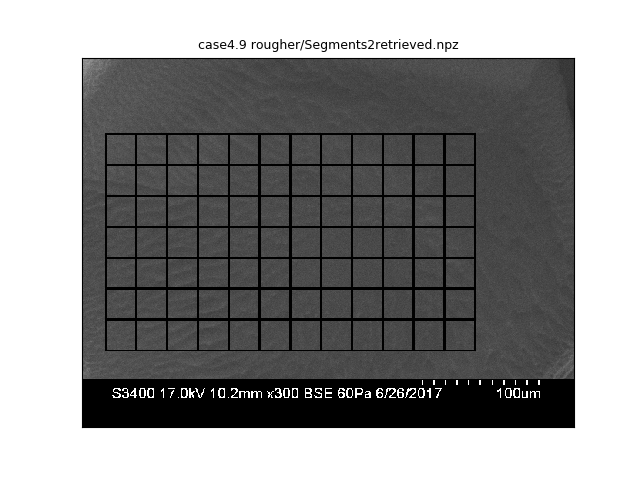

In [85]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
fig, ax = plt.subplots()
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
ax.set_title(Compressedfilename,fontsize=fontsize*0.9)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
Iwantmicrons = False
if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)


In [86]:
import itertools
def polyfit2d(x, y, z, order=3, linear=False):
    """Two-dimensional polynomial fit. Based uppon code provided by 
    Joe Kington.

    References:
        http://stackoverflow.com/questions/7997152/
            python-3d-polynomial-surface-fit-order-dependent/7997925#7997925

    """
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
        if linear & (i != 0.) & (j != 0.):
            G[:, k] = 0
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    """Values to two-dimensional polynomial fit. Based upon code 
        provided by Joe Kington.
    """
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z


def flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Rotx):
    # Rotates every point in the dataset
    thisshape = np.shape(surf_xseggrid)
    surf_xseggridp = np.zeros(thisshape)
    surf_yseggridp = np.zeros(thisshape)
    surf_zseggridp = np.zeros(thisshape)
    for ix in range (thisshape[1]):
        for iy in range (thisshape[0]):
            vec = np.matrix([surf_xseggrid[iy,ix],surf_yseggrid[iy,ix],surf_zseggrid[iy,ix]]).T
            vecp = Rotx*vec
            surf_xseggridp[iy,ix] = vecp[0]
            surf_yseggridp[iy,ix] = vecp[1]
            surf_zseggridp[iy,ix] = vecp[2]
    return surf_xseggridp, surf_yseggridp, surf_zseggridp

def pWeibull(r, sigma, eta):
    ''' Weibull function to be fit. '''

    from numpy import exp

    mu = 1-r
    ret = 2*eta/sigma**2/mu**3 * \
        (((mu**(-2)-1)/sigma**2)**(eta-1)) * \
        exp(-((mu**(-2)-1)/sigma**2)**eta)
    return ret

In [87]:
# Setting up null arrays
hbins_accum = []
meanrsub_accum = []
zsigma_accum = []
Z2_accum = []
Zsquared_accum = []
rsub_accum = []
meanrsublist = []
Zsigmalist = []
Z2list = []

# And a graphics parameter
stride = 1

In [88]:
# Now, to evaluate the roughness ... First step is to flatten each panel via rotation
# Here we explicitly flip the y-coordinate (to make it a right-handed system) so we don't have to invert on the fly
if Iwantroughness:
    
    # Sets up an output folder
    directory = case
    if not os.path.exists(directory):
        os.makedirs(directory)


    for isegment in range(0,nsegments):
    #for isegment in range(15,16):

        # Extract this segment
        nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
        ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
        surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
        surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
        surf_xseggrid, surf_yseggrid = np.meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
        surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

        # Fit a plane to the data and adjust data to start at the origin
        m = polyfit2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      surf_zseggrid.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angles of the plane
        dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

        # Get rotation matrix & flatten in one direction
        Roty = ims.myrotation_matrix([1,0,0], -thetay)
        surf_xseggridp, surf_yseggridp, surf_zseggridp = \
            flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

        # Fit a plane to the data and adjust data to start at the origin
        mp = polyfit2d(\
                      surf_xseggridp.reshape(nysegment*nxsegment), \
                      surf_yseggridp.reshape(nysegment*nxsegment), \
                      surf_zseggridp.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angle of the plane in another direction
        dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

        # Get rotation matrix & flatten in another direction
        Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
        surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
            flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)

            
        # Trying out the polyval2d
        surf_zseggrid_theory_long = polyval2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      m)
        surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
        #surf_zseggrid_theory -= z0
        surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
            flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
        surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
            flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

        # Now rotate
        deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
        deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
        thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
        Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
        surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
            flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
        surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
            flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

        # Now we have to extract an orthogonal subset
        dxsub = dysub = dx
        xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
        xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
        ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
        ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
        xsub = np.arange(xsubstart,xsubstop,dxsub)
        ysub = np.arange(ysubstart,ysubstop,dysub)
        sub_xseggrid, sub_yseggrid = np.meshgrid(xsub,ysub) # 1st index is y, 2nd is x
        nsuby, nsubx = np.shape(sub_xseggrid)
        surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
        surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
        points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
        values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
        sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
        sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))
        
        # Now we get the roughness
        dzsub_dx = np.diff(sub_zseggrid,axis=1)/np.diff(sub_xseggrid,axis=1)
        dzsub_dy = np.diff(sub_zseggrid,axis=0)/np.diff(sub_yseggrid,axis=0)
        Zsquared = dzsub_dx[1:,:]**2+dzsub_dy[:,1:]**2
        rsub = 1.0 - 1/np.sqrt(1+Zsquared)
        mu = 1-rsub
        phi = np.arccos(mu)
        Zplus = Zsquared**.5
        Z = np.hstack((Zplus,-Zplus)) # Need +/- to generate a two-sided distribution
        thismeanrsub = np.round(np.mean(rsub)*1000)/1000; meanrsublist.append(thismeanrsub)
        thissigma = np.round(np.std(Z)*100)/100; Zsigmalist.append(thissigma)
        thismeanZ2 = np.mean(Zsquared); Z2list.append(thismeanZ2)
        
        # Plotting surfaces
        title1 = 'panel_' +list(map(str,[isegment+1]))[0]#"TypeError: 'map' object is not subscriptable" stackoverflow said added the list() so the map is indexable
        
        # Numerical distribution functions
        rsub_long = np.reshape(rsub,np.size(rsub))
        
        # This needs to be changed to adjust for log spacing
        newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
        hist = np.histogram(rsub_long,bins=newrbins)
        
        rbins = hist[1][0:-1]
        rbins1 = hist[1][1:]
        hbins = hist[0] 
        norm = -np.trapz(rbins,hbins)
        hbins = hbins/norm
        
        # Defining the analytical distribution function bins
        rwidth = rbins1-rbins
        rbinsW = (rbins+rwidth/2.0)        
                
        # Accumulate the binned data
        if isegment in accumlist:
            hbins_accum.append(hbins)
            meanrsub_accum.append(thismeanrsub)
            zsigma_accum.append(thissigma)
            Z2_accum.append(thismeanZ2)
            
            Zsquared_long = np.reshape(Zsquared,np.size(Zsquared))
            Zsquared_accum = np.append(Zsquared_accum,Zsquared_long)
            
            rsub_long = np.reshape(rsub,np.size(rsub))
            rsub_accum = np.append(rsub_accum,rsub_long)
            
            print('Accumulating ...', np.shape(Zsquared), np.shape(Zsquared_long), np.shape(Zsquared_accum))
            

print(newrbins)
for isegment in range(len(meanrsublist)):
    print('segment, #pts, <r>, sigma =', \
        isegment, np.size(rsub), meanrsublist[isegment], Zsigmalist[isegment])

/Users/nesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Accumulating ... (36, 35) (1260,) (1260,)
Accumulating ... (36, 35) (1260,) (2520,)
Accumulating ... (36, 35) (1260,) (3780,)
Accumulating ... (36, 35) (1260,) (5040,)
Accumulating ... (37, 34) (1258,) (6298,)
Accumulating ... (37, 34) (1258,) (7556,)
Accumulating ... (38, 33) (1254,) (8810,)
Accumulating ... (36, 35) (1260,) (10070,)
Accumulating ... (36, 35) (1260,) (11330,)
Accumulating ... (36, 35) (1260,) (12590,)
Accumulating ... (36, 35) (1260,) (13850,)
Accumulating ... (36, 35) (1260,) (15110,)
Accumulating ... (37, 35) (1295,) (16405,)
Accumulating ... (37, 34) (1258,) (17663,)
Accumulating ... (36, 35) (1260,) (18923,)
Accumulating ... (36, 35) (1260,) (20183,)
Accumulating ... (36, 35) (1260,) (21443,)
Accumulating ... (36, 35) (1260,) (22703,)
Accumulating ... (36, 35) (1260,) (23963,)
Accumulating ... (37, 34) (1258,) (25221,)
Accumulating ... (37, 34) (1258,) (26479,)
Accumulating ... (36, 35) (1260,) (27739,)
Accumulating ... (36, 36) (1296,) (29035,)
Accumulating ... (

<IPython.core.display.Javascript object>


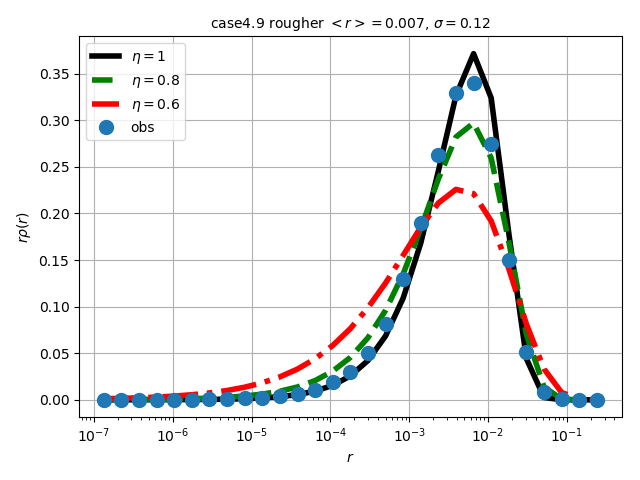

<Z2> =  0.013559785207496773
<r> =  0.006627762448579866
sigma =  0.124411052711248
Predicted eta =  0.8782883512939034


In [95]:
# This graphs observed and Weibull results

if Iwantlog:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hbins_total = np.sum((hbins_accum),axis=0)/len(accumlist)
    Zsigma_total = np.sum(zsigma_accum)/len(accumlist)
    meanrsub_total = np.sum(meanrsub_accum)/len(accumlist); meanrsub_total=np.round(meanrsub_total*1000)/1000
    
    MTTF = np.sum(Z2_accum)/len(accumlist)
    rMTTF = np.sqrt(MTTF)
    rMTTF_legend = np.round(np.mean(rMTTF)*100)/100
    
    meanZ2 = np.mean(Zsquared_accum); #print '<Z2> = ', meanZ2 
    sigma2 = np.std(Zsquared_accum); #print 'std(Z2) = ', sigma2
    sigma_legend = np.round(np.mean(sigma2**.5)*100)/100
    meanr = np.mean(rsub_accum); #print '<r>, 2*<r> = ', meanr, 2*meanr
    Rval = meanZ2/sigma2
    alpha = (np.pi**2-9.0)/6
    eta_predicted = Rval + alpha*(1-Rval)**2
    sigmaW2_predicted = meanZ2/gamma(1.0/eta_predicted+1)
    print('<Z2> = ', meanZ2)
    print('<r> = ', meanr)
    print('sigma = ', sigma2**.5)
    print( 'Predicted eta = ', eta_predicted)

#     sigmaW2_visual = meanZ2/gamma(1.0/eta_visual+1)
#     print('Using visual eta, predicted sigma_W = ', sigmaW2_visual**.5)
#     print('Using eta = ', eta_visual)

    eta = 1; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5
    hbinsW1 = pWeibull(rbinsW, sigma, eta)
    hbinsW1_times_r = hbinsW1*rbinsW
    norm = -np.trapz(np.log(rbinsW),hbinsW1_times_r); hbinsW1_times_r = hbinsW1_times_r/norm        
    
    eta = 0.8; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5
    hbinsW2 = pWeibull(rbinsW, sigma, eta)
    hbinsW2_times_r = hbinsW2*rbinsW
    norm = -np.trapz(np.log(rbinsW),hbinsW2_times_r); hbinsW2_times_r = hbinsW2_times_r/norm        

    eta = 0.6; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5
    hbinsW3 = pWeibull(rbinsW, sigma, eta)
    hbinsW3_times_r = hbinsW3*rbinsW
    norm = -np.trapz(np.log(rbinsW),hbinsW3_times_r); hbinsW3_times_r = hbinsW3_times_r/norm  
    
    norm = -np.trapz(np.log(rbins),hbins_total); hbins_total = hbins_total/norm

    ax.semilogx(rbinsW,hbinsW1_times_r,'k-',linewidth=4, label=r'$\eta=1$')
    ax.semilogx(rbinsW,hbinsW2_times_r,'g--',linewidth=4, label=r'$\eta=0.8$')
    ax.semilogx(rbinsW,hbinsW3_times_r,'r-.',linewidth=4, label=r'$\eta=0.6$')
    ax.semilogx(rbinsW,hbins_total,'o',markersize=10, label='obs')

    ax.set_xlabel(r'$r$',fontsize=fontsize)
    ax.set_ylabel(r'$r\rho(r)$',fontsize=fontsize)
    ax.legend(loc='upper left')
    ax.grid(True)
    title2 = r' $<r>=$'+list(map(str,[meanrsub_total]))[0]+r', $\sigma=$'+list(map(str,[sigma_legend]))[0]
    ax.set_title(case+title2,fontsize=fontsize)
    plt.tight_layout()
    #print 'total r, sigma:', meanrsub_total, Zsigma_total


In [90]:
if Iwanttosave:
    fig.savefig(Roughnessfile)